# Climate Analysis

In [69]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sqlalchemy import create_engine, MetaData, Table, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from flask import Flask, jsonify


In [70]:
# Use SQLAlchemy `create_engine` to connect to your sqlite database.
engine = create_engine('sqlite:///Resources/hawaii.sqlite')
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [71]:
# inspect tables and columns
inspector = inspect(engine)

inspector.get_table_names()

['Measurements', 'Stations']

In [72]:
# print the keys for the created classes
Base.classes.keys()

['Measurements', 'Stations']

In [73]:
# print list of column names for Measurements
columns_M = inspector.get_columns('Measurements')

for column in columns_M:
    print(column['name'], column['type'])

record_id INTEGER
station VARCHAR(255)
date DATE
precip FLOAT
temp FLOAT


In [74]:
# print list of column names for Stations
columns_S = inspector.get_columns('Stations')

for column in columns_S:
    print(column['name'], column['type'])

station_id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [75]:
# save a reference to those classes called `Station` and `Measurement`.
Station = Base.classes.Stations
Measurement = Base.classes.Measurements

# Create session
session = Session(engine)

In [76]:
# Check the data
for instance in session.query(Measurement.temp).limit(10).all():
    print(instance)

(65.0,)
(63.0,)
(74.0,)
(76.0,)
(73.0,)
(70.0,)
(64.0,)
(68.0,)
(73.0,)
(64.0,)


## Precipitation Analysis


In [77]:
# Retrieve the last 12 months of precipitation data. Select only the `date` and `prcp` values.
    # first find latest date, which turns out to be '2017-08-23'
Latest_date = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).first()
Latest_date = pd.to_datetime(Latest_date)
    # Note: HAVE to convert to datetime object first. Apparently python can't subtract from date object.
Latest_date = Latest_date[0] # selects the timestamp

    # subtract one year from it
year_date = Latest_date - timedelta(days=365)

year_date

Timestamp('2016-08-23 00:00:00')

In [78]:
# Query the last 12 months, averaging precip between the various weather stations
Last12Precip = session.query(Measurement.date, func.avg(Measurement.precip))\
                            .filter(Measurement.date >= year_date)\
                            .group_by(Measurement.date)\
                            .order_by(Measurement.date.desc())
    # note, specific datetime has to be this format 'yyyy-mm-dd' 
    
for instance in Last12Precip:
    print(instance)


(datetime.date(2017, 8, 23), 0.1325)
(datetime.date(2017, 8, 22), 0.16666666666666666)
(datetime.date(2017, 8, 21), 0.19333333333333336)
(datetime.date(2017, 8, 20), 0.005)
(datetime.date(2017, 8, 19), 0.03)
(datetime.date(2017, 8, 18), 0.02)
(datetime.date(2017, 8, 17), 0.0475)
(datetime.date(2017, 8, 16), 0.1525)
(datetime.date(2017, 8, 15), 0.164)
(datetime.date(2017, 8, 14), 0.062)
(datetime.date(2017, 8, 13), 0.0)
(datetime.date(2017, 8, 12), 0.04666666666666667)
(datetime.date(2017, 8, 11), 0.0)
(datetime.date(2017, 8, 10), 0.0175)
(datetime.date(2017, 8, 9), 0.049999999999999996)
(datetime.date(2017, 8, 8), 0.11000000000000001)
(datetime.date(2017, 8, 7), 0.0125)
(datetime.date(2017, 8, 6), 0.0)
(datetime.date(2017, 8, 5), 0.03)
(datetime.date(2017, 8, 4), 0.015)
(datetime.date(2017, 8, 3), 0.017499999999999998)
(datetime.date(2017, 8, 2), 0.075)
(datetime.date(2017, 8, 1), 0.04666666666666666)
(datetime.date(2017, 7, 31), 0.0)
(datetime.date(2017, 7, 30), 0.06)
(datetime.date(2

In [79]:
# saving dates and prcp values from the query
date = [row[0] for row in Last12Precip]
prcp = [row[1] for row in Last12Precip]

# checking if I only stored one value for each variable
print(date[0])

2017-08-23


In [80]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
Prcp_df = pd.DataFrame(list(zip(date, prcp)), columns=['date', 'prcp']) 
Prcp_df.set_index('date', inplace=True)
Prcp_df.head()

,prcp
date,
2017-08-23,0.132500
2017-08-22,0.166667
2017-08-21,0.193333
2017-08-20,0.005000
2017-08-19,0.030000


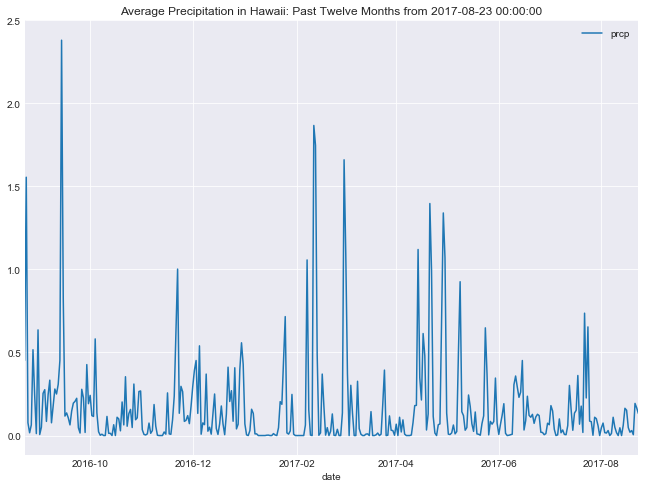

In [81]:
# Plot the results using the DataFrame `plot` method.
sns.set_style('darkgrid')
Prcp_df.plot(figsize=(11, 8))
plt.title('Average Precipitation in Hawaii: Past Twelve Months from ' + str(Latest_date))
plt.show()

In [82]:
# Summary stats for Prcp_df
Prcp_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Station Analysis

In [83]:
# Query to calculate the total number of stations.
station_num = session.query(Station.station_id).count()
print('Number of stations: ' + str(station_num))

Number of stations: 9


In [84]:
''' Query to find the most active stations.
  * List the stations and observation counts in descending order
  * Which station has the highest number of observations?
'''
station_active = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())

# Printing findings        
print('Station and activity count:')
print('**********************')

for instance in station_active:
    print(instance)

station_most = station_active[0][0]

print('**********************')
print('Most Active Station: ' + station_most)

Station and activity count:
**********************
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
**********************
Most Active Station: USC00519281


In [85]:
''' Query to retrieve the last 12 months of temperature observation data (tobs).
  * Filter by the station with the highest number of observations.
'''
Last_Temps = session.query(Measurement.date, Measurement.temp)\
            .filter(Measurement.station==station_most, Measurement.date >= year_date)

# Check if query was correct 
for item in Last_Temps:
    print(item)

(datetime.date(2016, 8, 23), 77.0)
(datetime.date(2016, 8, 24), 77.0)
(datetime.date(2016, 8, 25), 80.0)
(datetime.date(2016, 8, 26), 80.0)
(datetime.date(2016, 8, 27), 75.0)
(datetime.date(2016, 8, 28), 73.0)
(datetime.date(2016, 8, 29), 78.0)
(datetime.date(2016, 8, 30), 77.0)
(datetime.date(2016, 8, 31), 78.0)
(datetime.date(2016, 9, 1), 80.0)
(datetime.date(2016, 9, 2), 80.0)
(datetime.date(2016, 9, 3), 78.0)
(datetime.date(2016, 9, 4), 78.0)
(datetime.date(2016, 9, 5), 78.0)
(datetime.date(2016, 9, 6), 73.0)
(datetime.date(2016, 9, 7), 74.0)
(datetime.date(2016, 9, 8), 80.0)
(datetime.date(2016, 9, 9), 79.0)
(datetime.date(2016, 9, 10), 77.0)
(datetime.date(2016, 9, 11), 80.0)
(datetime.date(2016, 9, 12), 76.0)
(datetime.date(2016, 9, 13), 79.0)
(datetime.date(2016, 9, 14), 75.0)
(datetime.date(2016, 9, 15), 79.0)
(datetime.date(2016, 9, 16), 78.0)
(datetime.date(2016, 9, 17), 79.0)
(datetime.date(2016, 9, 18), 78.0)
(datetime.date(2016, 9, 19), 78.0)
(datetime.date(2016, 9, 20), 

In [86]:
# * Load the query results into a Pandas DataFrame and set the index to the date column.
Date = [row[0] for row in Last_Temps]
Temps = [row[1] for row in Last_Temps]
Last_Temps_df = pd.DataFrame(list(zip(Date, Temps)), columns=['date', 'temp'])
Last_Temps_df.tail()

,date,temp
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0
351,2017-08-18,79.0


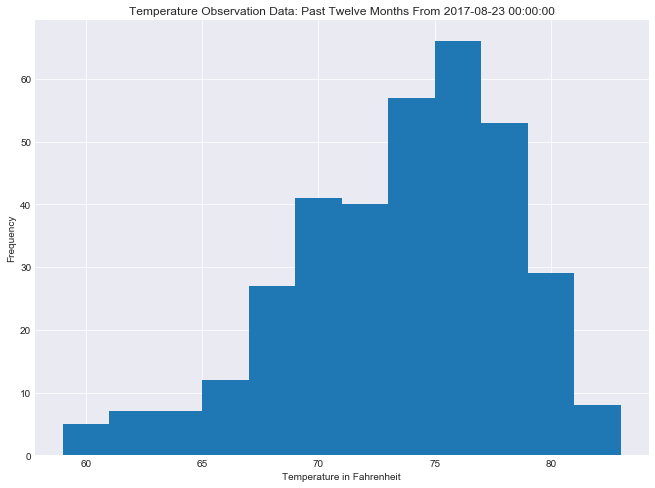

In [87]:
# Plot the results as a histogram with `bins=12`.
Last_Temps_df.hist(figsize=(11, 8), bins=12)
plt.title('Temperature Observation Data: Past Twelve Months From ' + str(Latest_date))
plt.xlabel('Temperature in Fahrenheit')
plt.ylabel('Frequency')
plt.show()

## Temperature Analysis

In [88]:
''' Write a function called `calc_temps` that will accept a start date and end date 
    in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures 
    for that range of dates.
'''
def calc_temps(start_date, end_date):
    try:
        temp_range = session.query(Measurement.date, func.min(Measurement.temp), \
                    func.avg(Measurement.temp), func.max(Measurement.temp))\
                    .filter(Measurement.date.between(start_date, end_date))\
                    .group_by(Measurement.date)\
                    .order_by(Measurement.date)
        return(temp_range)
        
    except ValueError:
        print('There was a wrong parameter!')


In [89]:
# Calculate tempuratures for my "vacation"
    # This years vacation is from '2017-08-20' to '2017-08-27'
    # I will use last year's values to calculate what to expect on this year's trip
vacation = calc_temps('2016-08-20', '2016-08-27')

for days in vacation:
    print(days)

(datetime.date(2016, 8, 20), 76.0, 79.66666666666667, 81.0)
(datetime.date(2016, 8, 21), 74.0, 77.0, 80.0)
(datetime.date(2016, 8, 22), 72.0, 77.28571428571429, 80.0)
(datetime.date(2016, 8, 23), 74.0, 78.28571428571429, 81.0)
(datetime.date(2016, 8, 24), 74.0, 77.57142857142857, 80.0)
(datetime.date(2016, 8, 25), 77.0, 79.42857142857143, 81.0)
(datetime.date(2016, 8, 26), 78.0, 80.5, 84.0)
(datetime.date(2016, 8, 27), 73.0, 76.83333333333333, 81.0)


In [90]:
# Save vacation weather data into a df
vacation_dic = {'date':[], 'min_temp':[], 'avg_temp':[], 'max_temp':[], 'range_temp':[]}
for day in vacation:
    vacation_dic['date'].append(day[0])
    vacation_dic['min_temp'].append(day[1])
    vacation_dic['avg_temp'].append(day[2])
    vacation_dic['max_temp'].append(day[3])
    vacation_dic['range_temp'].append(day[3] - day[1]) # The day's Max temp - min temp
    
vacation_df = pd.DataFrame(vacation_dic)
vacation_df.set_index('date', inplace=True)

vacation_df

,avg_temp,max_temp,min_temp,range_temp
date,,,,
2016-08-20,79.666667,81.0,76.0,5.0
2016-08-21,77.000000,80.0,74.0,6.0
2016-08-22,77.285714,80.0,72.0,8.0
2016-08-23,78.285714,81.0,74.0,7.0
2016-08-24,77.571429,80.0,74.0,6.0
2016-08-25,79.428571,81.0,77.0,4.0
2016-08-26,80.500000,84.0,78.0,6.0
2016-08-27,76.833333,81.0,73.0,8.0


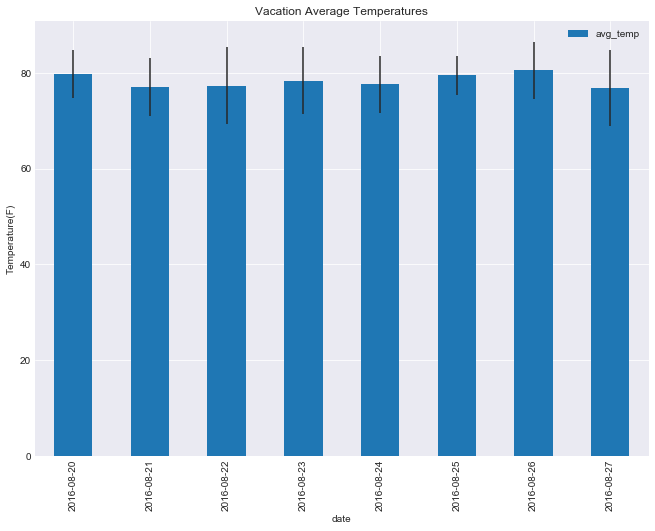

In [91]:
'''Plot the min, avg, and max temperature from your previous query as a bar chart.
  * Use the average temperature as the bar height.
  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
'''
vacation_df.plot(x=vacation_df.index, y='avg_temp', kind='bar', yerr='range_temp', figsize=(11, 8))
plt.title("Vacation Average Temperatures")
plt.ylabel('Temperature(F)')
plt.show()

## Climate App, a Flask api

In [115]:
# design a Flask api based on the queries that you have just developed.
app = Flask(__name__)

# App route at the start
@app.route('/')
def welcome():
    # Returns strings informing user of all available api routes
        # note: HTML line breaks work here, not python \n
    return("Welcome to my Hawaii Weather API! </br>" 
        "Available api routes: </br>"
        "Average Precipitation for the last 12 months: /api/v1.0/precipitation </br>"
        "List of Stations: /api/v1.0/stations </br>"
        "List of Temperature Observations (tobs) for the last 12 months: /api/v1.0/tobs </br>"
        "List of temperatures for a given start range: /api/v1.0/start_date </br>"
        "List of temperatures for a given start-end range: /api/v1.0/start_date/end_date </br>"
        "Note: start_date and end_date are variables of dates (format: YYYY-MM-DD)"
    )


In [116]:
# API route for json of precipitation
    # See Precipitation Analysis section for prcp variables used here
@app.route('/api/v1.0/precipitation')
def show_precip():
    data = []
    '''from the previous query: 
    date = [row[0] for row in Last12Precip]
    prcp = [row[1] for row in Last12Precip]'''
    data_row_count = 0
    for row in Last12Precip:
        data.append({'date':row[0], 'avg_prcp':row[1]})
    return jsonify(data)

In [117]:
# Test to see if the for loop within show_precip() worked
data = []
for row in Last12Precip:
        data.append({'date':row[0], 'avg_prcp':row[1]})
print(str(data[0]))

{'date': datetime.date(2017, 8, 23), 'avg_prcp': 0.1325}


In [118]:
# API route for a list of stations from the dataset
@app.route('/api/v1.0/stations')
def show_stations():
    station_ls = []
    stations_qry = session.query(Station.station)
    for row in stations_qry:
        station_ls.append(row[0])
    return jsonify(station_ls)

In [119]:
# Test to see if the for loop within show_stations() worked
station_ls = []
stations_qry = session.query(Station.station)
for row in stations_qry:
    station_ls.append(row[0])

print(station_ls)


['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128']


In [120]:
# API route for json of Temperature Observations (tobs) for the last 12 months
@app.route('/api/v1.0/tobs')
def show_tobs():
    temps_ls = [] 
    all_temps = calc_temps(year_date, Latest_date) 
        # note: year_date and Latest_date are in precipitation analysis section
    for days in all_temps:
        temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    return jsonify(temps_ls)

In [121]:
# Test to see if the for loop within show_tobs() worked

temps_ls = [] 
all_temps = calc_temps(year_date, Latest_date)
for days in all_temps:
    temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    
print(temps_ls[0:2])
print(temps_ls[-1])

[{'date': datetime.date(2016, 8, 23), 'min_temp': 74.0, 'avg_temp': 78.28571428571429, 'max_temp': 81.0}, {'date': datetime.date(2016, 8, 24), 'min_temp': 74.0, 'avg_temp': 77.57142857142857, 'max_temp': 80.0}]
{'date': datetime.date(2017, 8, 23), 'min_temp': 76.0, 'avg_temp': 80.25, 'max_temp': 82.0}


In [122]:
# API route for json of temps for a given start or start-end range.
@app.route('/api/v1.0/<start>/<end>')
def temps_api_dates(start = Latest_date, end = Latest_date): #Latest_date var at Precip'n analysis section
    temps_ls = []
    get_temps = calc_temps(start, end)
    for days in get_temps:
        temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    return jsonify(temps_ls)

In [123]:
# Test to see if the for loop within temps_api_dates() worked
def temps_api_dates(start, end = Latest_date): #Latest_date var at Precip'n analysis section
    temps_ls = []
    get_temps = calc_temps(start, end)
    for days in get_temps:
        temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    return temps_ls

for i in temps_api_dates('2017-08-16'):
    print(i)

{'date': datetime.date(2017, 8, 16), 'min_temp': 71.0, 'avg_temp': 77.0, 'max_temp': 82.0}
{'date': datetime.date(2017, 8, 17), 'min_temp': 72.0, 'avg_temp': 77.25, 'max_temp': 83.0}
{'date': datetime.date(2017, 8, 18), 'min_temp': 76.0, 'avg_temp': 78.0, 'max_temp': 80.0}
{'date': datetime.date(2017, 8, 19), 'min_temp': 71.0, 'avg_temp': 78.75, 'max_temp': 85.0}
{'date': datetime.date(2017, 8, 20), 'min_temp': 78.0, 'avg_temp': 79.66666666666667, 'max_temp': 81.0}
{'date': datetime.date(2017, 8, 21), 'min_temp': 76.0, 'avg_temp': 79.5, 'max_temp': 82.0}
{'date': datetime.date(2017, 8, 22), 'min_temp': 76.0, 'avg_temp': 80.0, 'max_temp': 82.0}
{'date': datetime.date(2017, 8, 23), 'min_temp': 76.0, 'avg_temp': 80.25, 'max_temp': 82.0}


In [ ]:
'''May need to create @app.route('/api/v1.0/<start>') since route with both start
    and end dates returns 404 error if only one date is inputted
'''

In [124]:
# run app
if __name__ == '__main__':
    app.run()


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Jan/2018 01:31:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Jan/2018 01:31:22] "GET /api/v1.0/2017-08-16/2017-08-20 HTTP/1.1" 200 -
127.0.0.1 - - [28/Jan/2018 01:31:29] "GET /api/v1.0/2017-08-16/ HTTP/1.1" 404 -
127.0.0.1 - - [28/Jan/2018 01:31:32] "GET /api/v1.0/2017-08-16 HTTP/1.1" 404 -
